In [2]:
# @title
# Install required packages
!pip install earthengine-api geemap pandas numpy scikit-learn xgboost statsmodels plotly dash geopandas folium

# Import libraries
import ee
import geemap
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
import geopandas as gpd
from datetime import datetime, timedelta
import requests
import json

ee.Authenticate()
ee.Initialize(project = 'greenaihackathon-476122')

print("✓ All packages installed!")

✓ All packages installed!


In [3]:
# @title
# Define SF Bay Area bounding box
sf_bay_bounds = ee.Geometry.Rectangle([-122.6, 37.2, -121.5, 38.2])

# Load watershed boundaries (HUC-8 or HUC-10)
watersheds = ee.FeatureCollection("USGS/WBD/2017/HUC08") \
    .filterBounds(sf_bay_bounds)

# Visualize with geemap
Map = geemap.Map(center=[37.8, -122.4], zoom=9)
Map.addLayer(sf_bay_bounds, {'color': 'red'}, 'SF Bay Area')
Map.addLayer(watersheds, {'color': 'blue'}, 'Watersheds')
Map

Map(center=[37.8, -122.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [4]:
# @title
class GEEFeatureExtractor:
    """Extract environmental features from Google Earth Engine"""

    def __init__(self, start_date='2020-01-01', end_date='2024-12-31'):
        self.start_date = start_date
        self.end_date = end_date
        self.sf_bay = ee.Geometry.Rectangle([-122.6, 37.2, -121.5, 38.2])

    def get_land_cover_features(self, geometry, year=2021):
        """Extract land cover percentages from NLCD"""

        # Load NLCD
        nlcd = ee.ImageCollection('USGS/NLCD_RELEASES/2021_REL/NLCD') \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .first() \
            .select('landcover') \
            .clip(geometry)

        # Define land cover classes
        # 11: Open Water, 21-24: Developed, 41-43: Forest, 52: Shrub, 71: Grassland, 81-82: Agriculture, 90-95: Wetlands

        # Calculate area for each class
        area_image = ee.Image.pixelArea().addBands(nlcd)

        areas = area_image.reduceRegion(
            reducer=ee.Reducer.sum().group(
                groupField=1,
                groupName='landcover'
            ),
            geometry=geometry,
            scale=30,
            maxPixels=1e9
        )

        # Convert to dictionary
        class_areas = areas.getInfo()['groups']

        # Calculate percentages
        total_area = sum([item['sum'] for item in class_areas])

        features = {}
        for item in class_areas:
            lc_class = item['landcover']
            pct = (item['sum'] / total_area) * 100

            if lc_class in [21, 22, 23, 24]:  # Developed
                features['developed_pct'] = features.get('developed_pct', 0) + pct
            elif lc_class in [41, 42, 43]:  # Forest
                features['forest_pct'] = features.get('forest_pct', 0) + pct
            elif lc_class in [81, 82]:  # Agriculture
                features['agriculture_pct'] = features.get('agriculture_pct', 0) + pct
            elif lc_class == 11:  # Water
                features['water_pct'] = pct
            elif lc_class in [90, 95]:  # Wetlands
                features['wetlands_pct'] = features.get('wetlands_pct', 0) + pct

        return features

    def get_impervious_surface(self, geometry):
        """Extract impervious surface percentage"""

        impervious = ee.ImageCollection('USGS/NLCD_RELEASES/2021_REL/NLCD') \
            .first() \
            .select('impervious') \
            .clip(geometry)

        mean_impervious = impervious.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=30,
            maxPixels=1e9
        )

        return {'impervious_pct': mean_impervious.getInfo()['impervious']}

    def get_ndvi_stats(self, geometry, start_date, end_date):
        """Calculate NDVI statistics from Sentinel-2"""

        def add_ndvi(image):
            ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
            return image.addBands(ndvi)

        # Load Sentinel-2 data
        sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(geometry) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
            .map(add_ndvi)

        # Calculate mean NDVI
        ndvi_mean = sentinel.select('NDVI').mean().clip(geometry)

        stats = ndvi_mean.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                reducer2=ee.Reducer.stdDev(),
                sharedInputs=True
            ),
            geometry=geometry,
            scale=100,
            maxPixels=1e9
        )

        stats_dict = stats.getInfo()
        return {
            'ndvi_mean': stats_dict.get('NDVI_mean', 0),
            'ndvi_std': stats_dict.get('NDVI_stdDev', 0)
        }

    def get_precipitation(self, geometry, start_date, end_date):
        """Get precipitation data from CHIRPS"""

        precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate(start_date, end_date) \
            .filterBounds(geometry)

        # Sum precipitation
        total_precip = precip.sum().clip(geometry)

        precip_stats = total_precip.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=5000,
            maxPixels=1e9
        )

        return {'precipitation_mm': precip_stats.getInfo()['precipitation']}

    def get_temperature(self, geometry, start_date, end_date):
        """Get temperature data from MODIS"""

        temp = ee.ImageCollection('MODIS/006/MOD11A2') \
            .filterDate(start_date, end_date) \
            .filterBounds(geometry) \
            .select('LST_Day_1km')

        # Convert from Kelvin to Celsius
        temp_celsius = temp.mean().multiply(0.02).subtract(273.15).clip(geometry)

        temp_stats = temp_celsius.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=1000,
            maxPixels=1e9
        )

        return {'temperature_celsius': temp_stats.getInfo()['LST_Day_1km']}

    def extract_all_features(self, geometry, date):
        """Extract all features for a given geometry and date"""

        features = {}

        # Date ranges
        date_obj = pd.to_datetime(date)
        end_date_str = date_obj.strftime('%Y-%m-%d')
        start_date_30d = (date_obj - timedelta(days=30)).strftime('%Y-%m-%d')
        start_date_90d = (date_obj - timedelta(days=90)).strftime('%Y-%m-%d')

        print(f"Extracting features for {date}...")

        # Land cover (static)
        try:
            features.update(self.get_land_cover_features(geometry))
        except Exception as e:
            print(f"  Land cover error: {e}")

        # Impervious surface (static)
        try:
            features.update(self.get_impervious_surface(geometry))
        except Exception as e:
            print(f"  Impervious surface error: {e}")

        # NDVI (30-day window)
        try:
            features.update(self.get_ndvi_stats(geometry, start_date_30d, end_date_str))
        except Exception as e:
            print(f"  NDVI error: {e}")

        # Precipitation (30-day total)
        try:
            features.update(self.get_precipitation(geometry, start_date_30d, end_date_str))
        except Exception as e:
            print(f"  Precipitation error: {e}")

        # Temperature (30-day average)
        try:
            features.update(self.get_temperature(geometry, start_date_30d, end_date_str))
        except Exception as e:
            print(f"  Temperature error: {e}")

        # Add temporal features
        features['month'] = date_obj.month
        features['season'] = (date_obj.month % 12 + 3) // 3
        features['year'] = date_obj.year
        features['day_of_year'] = date_obj.dayofyear

        return features

# Initialize extractor
extractor = GEEFeatureExtractor()
print("✓ GEE Feature Extractor initialized!")

✓ GEE Feature Extractor initialized!


In [5]:
# @title
def clean_ceden_data(ceden_data):
    """
    Clean CEDEN water quality data.

    Parameters:
    -----------
    ceden_data : pd.DataFrame
        Raw CEDEN data from TSV file

    Returns:
    --------
    pd.DataFrame
        Cleaned data with standardized columns
    """
    import pandas as pd
    import numpy as np

    # Make a copy to avoid modifying original
    df = ceden_data.copy()

    print(f"Initial rows: {len(df)}")

    # 1. KEEP ONLY FIELD SAMPLES (remove QA samples)
    # The 'isQA' column indicates QA samples
    df = df[df['isQA'] == False].copy()
    print(f"After removing QA samples: {len(df)}")

    # 2. FILTER BY RESULT QUALIFIERS
    # Remove non-detect (ND) and problematic qualifiers
    # Keep: '=' (detected), 'DNQ' (detected but not quantified)
    valid_qualifiers = ['=', 'DNQ', None, np.nan]
    df = df[df['ResultQualCode'].isin(valid_qualifiers) | df['ResultQualCode'].isna()].copy()
    print(f"After filtering result qualifiers: {len(df)}")

    # 3. KEEP ONLY WATER SAMPLES
    df = df[df['MatrixName'] == 'samplewater'].copy()
    print(f"After filtering to water samples: {len(df)}")

    # 4. STANDARDIZE DATE
    df['SampleDate'] = pd.to_datetime(df['SampleDate'], errors='coerce')
    df = df.dropna(subset=['SampleDate'])
    print(f"After date parsing: {len(df)}")

    # 5. ENSURE VALID COORDINATES
    df = df.dropna(subset=['latitude', 'longitude'])
    df = df[(df['latitude'] != 0) & (df['longitude'] != 0)]
    print(f"After coordinate validation: {len(df)}")

    # 6. CONVERT RESULT TO NUMERIC
    df['Result'] = pd.to_numeric(df['Result'], errors='coerce')

    # 7. REMOVE ROWS WITH MISSING CRITICAL VALUES
    df = df.dropna(subset=['Result', 'Analyte', 'StationCode'])
    print(f"After removing missing critical values: {len(df)}")

    # 8. STANDARDIZE COLUMN NAMES (keep key columns)
    columns_to_keep = {
        'StationCode': 'station_id',
        'StationName': 'station_name',
        'SampleDate': 'date',
        'Analyte': 'parameter',
        'Result': 'value',
        'Unit': 'unit',
        'latitude': 'latitude',
        'longitude': 'longitude',
        'ResultQualCode': 'qualifier',
        'CollectionDepth': 'depth_m',
        'Program': 'program',
        'county': 'county'
    }

    df = df.rename(columns=columns_to_keep)
    df = df[[col for col in columns_to_keep.values() if col in df.columns]]

    # 9. REMOVE DUPLICATES (keep first occurrence)
    # Based on station, date, parameter
    df = df.drop_duplicates(subset=['station_id', 'date', 'parameter'], keep='first')
    print(f"After removing duplicates: {len(df)}")

    # 10. SORT BY STATION AND DATE
    df = df.sort_values(['station_id', 'date']).reset_index(drop=True)

    print(f"\nFinal cleaned rows: {len(df)}")
    print(f"Unique stations: {df['station_id'].nunique()}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Parameters: {sorted(df['parameter'].unique())}")

    return df

In [6]:
# @title
def transform_ceden_to_wide(ceden_clean):
    """
    Transform cleaned CEDEN data from long to wide format.
    Pivots so each parameter becomes a column.

    Parameters:
    -----------
    ceden_clean : pd.DataFrame
        Cleaned CEDEN data from clean_ceden_data()

    Returns:
    --------
    pd.DataFrame
        Wide format with one row per station-date, parameters as columns
    """
    import pandas as pd
    import numpy as np

    print(f"Input rows: {len(ceden_clean)}")
    print(f"Unique parameters: {ceden_clean['parameter'].nunique()}")

    # 1. CREATE STANDARDIZED PARAMETER NAMES (lowercase, underscores)
    def standardize_parameter_name(param):
        """Convert parameter names to clean column names"""
        # Remove special characters, convert to lowercase
        clean = str(param).lower()
        clean = clean.replace(',', '').replace('.', '')
        clean = clean.replace('  ', ' ').strip()
        clean = clean.replace(' ', '_')
        clean = clean.replace('-', '_')
        return clean

    ceden_clean['parameter_clean'] = ceden_clean['parameter'].apply(standardize_parameter_name)

    # 2. SHOW PARAMETER MAPPING
    param_mapping = ceden_clean[['parameter', 'parameter_clean']].drop_duplicates()
    print("\nParameter name mapping:")
    for _, row in param_mapping.iterrows():
        print(f"  {row['parameter']} -> {row['parameter_clean']}")

    # 3. HANDLE MULTIPLE MEASUREMENTS ON SAME DATE
    # Take mean if multiple values exist for same station-date-parameter
    agg_df = ceden_clean.groupby(
        ['station_id', 'station_name', 'date', 'latitude', 'longitude',
         'parameter_clean', 'unit', 'county', 'program'],
        dropna=False
    ).agg({
        'value': 'mean',  # Average if multiple samples
        'qualifier': 'first'  # Keep first qualifier
    }).reset_index()

    print(f"\nAfter aggregation: {len(agg_df)} rows")

    # 4. ADD UNIT TO PARAMETER NAME (to avoid conflicts with different units)
    # e.g., "nitrogen_total_mg_l" vs "nitrogen_total_ug_l"
    def add_unit_to_param(row):
        param = row['parameter_clean']
        unit = str(row['unit']).lower() if pd.notna(row['unit']) else ''

        # Clean unit string
        unit = unit.replace('/', '_').replace(' ', '').replace('.', '')

        if unit and unit != 'nan':
            return f"{param}_{unit}"
        return param

    agg_df['parameter_with_unit'] = agg_df.apply(add_unit_to_param, axis=1)

    # 5. PIVOT TO WIDE FORMAT
    # Keep station metadata separate
    metadata_cols = ['station_id', 'station_name', 'date', 'latitude', 'longitude', 'county', 'program']

    wide_df = agg_df.pivot_table(
        index=metadata_cols,
        columns='parameter_with_unit',
        values='value',
        aggfunc='first'  # Safety in case there are still duplicates
    ).reset_index()

    # 6. CLEAN UP COLUMN NAMES
    wide_df.columns.name = None  # Remove the 'parameter_with_unit' label

    print(f"\nWide format created:")
    print(f"  Rows (station-date combinations): {len(wide_df)}")
    print(f"  Columns: {len(wide_df.columns)}")
    print(f"  Parameter columns: {len(wide_df.columns) - len(metadata_cols)}")

    # 7. SHOW SAMPLE OF PARAMETER COLUMNS
    param_cols = [col for col in wide_df.columns if col not in metadata_cols]
    print(f"\nParameter columns created:")
    for col in sorted(param_cols)[:20]:  # Show first 20
        non_null = wide_df[col].notna().sum()
        print(f"  {col}: {non_null} non-null values")
    if len(param_cols) > 20:
        print(f"  ... and {len(param_cols) - 20} more")

    # 8. SORT BY STATION AND DATE
    wide_df = wide_df.sort_values(['station_id', 'date']).reset_index(drop=True)

    return wide_df
"""
What this function does:

1. **Standardizes parameter names**: Converts "Chlorophyll a, Total" → "chlorophyll_a_total"
2. **Handles duplicates**: Averages multiple measurements on same date
3. **Adds units to parameter names**: "nitrogen_total_mg/L" becomes "nitrogen_total_mg_l" to distinguish from "nitrogen_total_ug_l"
4. **Pivots to wide format**: Each parameter becomes its own column
5. **Preserves metadata**: Station ID, name, coordinates, date stay as index columns

**Expected output structure:**

station_id | date       | latitude | longitude | chlorophyll_a_total_mg_m3 | nitrogen_total_mg_l | ...
-----------|------------|----------|-----------|---------------------------|---------------------|----
205COY222  | 2020-09-14 | 37.289   | -121.765  | NaN                       | NaN                 | ...
205COY182  | 2020-09-14 | 37.358   | -121.859  | 5.3                       | NaN                 | ...
"""

'\nWhat this function does:\n\n1. **Standardizes parameter names**: Converts "Chlorophyll a, Total" → "chlorophyll_a_total"\n2. **Handles duplicates**: Averages multiple measurements on same date\n3. **Adds units to parameter names**: "nitrogen_total_mg/L" becomes "nitrogen_total_mg_l" to distinguish from "nitrogen_total_ug_l"\n4. **Pivots to wide format**: Each parameter becomes its own column\n5. **Preserves metadata**: Station ID, name, coordinates, date stay as index columns\n\n**Expected output structure:**\n\nstation_id | date       | latitude | longitude | chlorophyll_a_total_mg_m3 | nitrogen_total_mg_l | ...\n-----------|------------|----------|-----------|---------------------------|---------------------|----\n205COY222  | 2020-09-14 | 37.289   | -121.765  | NaN                       | NaN                 | ...\n205COY182  | 2020-09-14 | 37.358   | -121.859  | 5.3                       | NaN                 | ...\n'

In [7]:
# @title
def handle_ceden_issues(wq_data):
    """
    Handle common data quality issues in wide-format CEDEN data.

    Parameters:
    -----------
    wq_data : pd.DataFrame
        Wide-format water quality data from transform_ceden_to_wide()

    Returns:
    --------
    pd.DataFrame
        Cleaned data with issues resolved
    """
    import pandas as pd
    import numpy as np

    df = wq_data.copy()

    print(f"Initial shape: {df.shape}")
    print(f"Initial columns: {len(df.columns)}")

    # Identify metadata vs parameter columns
    metadata_cols = ['station_id', 'station_name', 'date', 'latitude', 'longitude', 'county', 'program']
    param_cols = [col for col in df.columns if col not in metadata_cols]

    print(f"Parameter columns: {len(param_cols)}")

    # 1. HANDLE NEGATIVE VALUES (concentrations can't be negative)
    print("\n1. Handling negative values...")
    negative_counts = {}
    for col in param_cols:
        if df[col].dtype in ['float64', 'int64']:
            neg_count = (df[col] < 0).sum()
            if neg_count > 0:
                negative_counts[col] = neg_count
                df.loc[df[col] < 0, col] = np.nan

    if negative_counts:
        print(f"   Set {sum(negative_counts.values())} negative values to NaN across {len(negative_counts)} parameters")
        for col, count in list(negative_counts.items())[:5]:
            print(f"     {col}: {count} negative values")
        if len(negative_counts) > 5:
            print(f"     ... and {len(negative_counts) - 5} more parameters")
    else:
        print("   No negative values found")

    # 2. DROP COLUMNS WITH >95% MISSING DATA
    print("\n2. Dropping sparse columns (>95% missing)...")
    missing_threshold = 0.95
    cols_to_drop = []

    for col in param_cols:
        missing_pct = df[col].isna().sum() / len(df)
        if missing_pct > missing_threshold:
            cols_to_drop.append(col)

    if cols_to_drop:
        print(f"   Dropping {len(cols_to_drop)} sparse columns:")
        for col in cols_to_drop[:10]:
            missing_pct = df[col].isna().sum() / len(df) * 100
            print(f"     {col}: {missing_pct:.1f}% missing")
        if len(cols_to_drop) > 10:
            print(f"     ... and {len(cols_to_drop) - 10} more")

        df = df.drop(columns=cols_to_drop)
        param_cols = [col for col in param_cols if col not in cols_to_drop]
    else:
        print("   No sparse columns to drop")

    # 3. REMOVE DUPLICATE ROWS (safety check)
    print("\n3. Checking for duplicate rows...")
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['station_id', 'date'], keep='first')
    removed = initial_rows - len(df)
    if removed > 0:
        print(f"   Removed {removed} duplicate station-date combinations")
    else:
        print("   No duplicates found")

    # 4. HANDLE EXTREME OUTLIERS (>99.9th percentile or <0.1th percentile)
    # Only flag, don't remove - let user decide
    print("\n4. Detecting extreme outliers...")
    outlier_summary = {}

    for col in param_cols:
        if df[col].dtype in ['float64', 'int64'] and df[col].notna().sum() > 10:
            q_low = df[col].quantile(0.001)
            q_high = df[col].quantile(0.999)

            outliers = ((df[col] < q_low) | (df[col] > q_high)) & df[col].notna()
            outlier_count = outliers.sum()

            if outlier_count > 0:
                outlier_summary[col] = {
                    'count': outlier_count,
                    'range': (q_low, q_high),
                    'extreme_values': df.loc[outliers, col].tolist()[:3]
                }

    if outlier_summary:
        print(f"   Found extreme outliers in {len(outlier_summary)} parameters")
        for col, info in list(outlier_summary.items())[:5]:
            print(f"     {col}: {info['count']} outliers (normal range: {info['range'][0]:.2f} - {info['range'][1]:.2f})")
        if len(outlier_summary) > 5:
            print(f"     ... and {len(outlier_summary) - 5} more parameters")
        print("   Note: Outliers retained in dataset (review before modeling)")
    else:
        print("   No extreme outliers detected")

    # 5. ENSURE PROPER DATA TYPES
    print("\n5. Standardizing data types...")
    df['date'] = pd.to_datetime(df['date'])
    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

    for col in param_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    print("   Data types standardized")

    # 6. REMOVE ROWS WITH MISSING COORDINATES
    print("\n6. Removing rows with invalid coordinates...")
    initial_rows = len(df)
    df = df.dropna(subset=['latitude', 'longitude'])
    removed = initial_rows - len(df)
    if removed > 0:
        print(f"   Removed {removed} rows with missing coordinates")
    else:
        print("   All rows have valid coordinates")

    # 7. SUMMARY STATISTICS
    print("\n" + "="*60)
    print("FINAL DATASET SUMMARY")
    print("="*60)
    print(f"Shape: {df.shape}")
    print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"Unique stations: {df['station_id'].nunique()}")
    print(f"Parameter columns: {len(param_cols)}")

    # Show completeness of remaining parameters
    print("\nParameter completeness (non-null %):")
    param_completeness = []
    for col in param_cols:
        completeness = (1 - df[col].isna().sum() / len(df)) * 100
        param_completeness.append((col, completeness))

    param_completeness.sort(key=lambda x: x[1], reverse=True)

    for col, pct in param_completeness[:10]:
        print(f"  {col}: {pct:.1f}%")
    if len(param_completeness) > 10:
        print(f"  ... and {len(param_completeness) - 10} more parameters")

    # Reset index
    df = df.reset_index(drop=True)

    return df

In [14]:
def extract_features_for_stations(wq_data, extractor, sample_size=20):
    """Extract GEE features for each station and date"""

    # Sample data for demonstration (remove sampling for full analysis)
    wq_sample = wq_data.sample(min(sample_size, len(wq_data)), random_state=42)

    all_features = []

    for idx, row in wq_sample.iterrows():
        print(f"Processing {idx+1}/{len(wq_sample)}...")

        # Create point geometry for station
        point = ee.Geometry.Point([row['longitude'], row['latitude']])

        # Create buffer (e.g., 5km radius)
        buffer = point.buffer(5000)

        # Extract features
        try:
            features = extractor.extract_all_features(buffer, row['date'])
            features['station_id'] = row['station_id']
            features['date'] = row['date']
            features['latitude'] = row['latitude']
            features['longitude'] = row['longitude']
            # Use .loc[] for more robust access
            # FIX: Correct column name for nitrogen and phosphorus based on transform_ceden_to_wide output
            features['nitrogen_mg_l'] = row.loc['nitrogen_total_kjeldahl_total_mg_l'] if 'nitrogen_total_kjeldahl_total_mg_l' in row.index else np.nan
            features['phosphorus_mg_l'] = row.loc['phosphorus_as_p_total_mg_l'] if 'phosphorus_as_p_total_mg_l' in row.index else np.nan

            all_features.append(features)
        except Exception as e:
            print(f"  Error processing row {idx}: {e}")
            continue

    df_features = pd.DataFrame(all_features)
    return df_features

# Extract features (this will take some time!)
print("Extracting GEE features for water quality stations...")
print("Note: Using sample of 50 measurements for demonstration")
print("Remove sample_size parameter for full dataset")

df_features = extract_features_for_stations(wq_data_clean, extractor, sample_size=50) # Use wq_data_clean as input

# Save to CSV
df_features.to_csv('sf_bay_features.csv', index=False)
print(f"✓ Extracted features for {len(df_features)} measurements")
print(df_features.head())

Extracting GEE features for water quality stations...
Note: Using sample of 50 measurements for demonstration
Remove sample_size parameter for full dataset
Processing 62/50...
Extracting features for 2022-04-26 00:00:00...
Processing 58/50...
Extracting features for 2022-05-11 00:00:00...
Processing 1/50...
Extracting features for 2022-05-24 00:00:00...
Processing 44/50...
Extracting features for 2023-12-20 00:00:00...
  Temperature error: Image.multiply: If one image has no bands, the other must also have no bands. Got 0 and 1.
Processing 6/50...
Extracting features for 2022-05-25 00:00:00...
Processing 37/50...
Extracting features for 2022-05-18 00:00:00...
Processing 17/50...
Extracting features for 2022-05-12 00:00:00...
Processing 13/50...
Extracting features for 2022-05-18 00:00:00...
Processing 26/50...
Extracting features for 2023-11-18 00:00:00...
  Temperature error: Image.multiply: If one image has no bands, the other must also have no bands. Got 0 and 1.
Processing 61/50...

In [10]:
# @title
def engineer_features(df_features):
    """
    Engineer features for water quality + GEE dataset.

    Steps:
    - Impute missing numerical and categorical values
    - Encode categorical variables
    - Scale numerical features
    - Add derived temporal features
    - Return engineered dataframe ready for modeling
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    df = df_features.copy()

    # --- 1. Missing value handling ---
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    # Exclude identifier columns from engineering
    exclude_cols = ['station_id', 'latitude', 'longitude', 'date']
    num_cols = [col for col in num_cols if col not in exclude_cols]
    cat_cols = [col for col in cat_cols if col not in exclude_cols]

    # Fill missing numeric values with mean
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())

    # Fill missing categorical values with mode
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if df[col].mode().size > 0 else 'missing')

    # --- 2. Temporal feature engineering ---
    # Convert date to datetime if not already
    if 'date' in df.columns and not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'])

    if 'date' in df.columns:
        df['day_of_week'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear

    # --- 3. Categorical encoding ---
    # One-hot encode categorical columns (e.g., season)
    if cat_cols:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(df[cat_cols])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
        df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

    # --- 4. Scaling numeric features ---
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[num_cols])
    scaled_df = pd.DataFrame(scaled, columns=[f"{col}_scaled" for col in num_cols], index=df.index)
    df = pd.concat([df, scaled_df], axis=1)

    # --- 5. Feature interactions (simple example) ---
    if 'ndvi_mean' in df.columns and 'precipitation_mm' in df.columns:
        df['ndvi_precip_interaction'] = df['ndvi_mean'] * df['precipitation_mm']

    # Drop original lat/lon identifiers if desired
    # df = df.drop(columns=['latitude', 'longitude'])

    return df


In [11]:
# @title
class WaterQualityPredictor:
    """
    End-to-end water quality prediction using Google Earth Engine features.

    Supports multiple models and provides comprehensive evaluation metrics.
    """

    def __init__(self, target_variable='dissolved_oxygen', model_type='random_forest'):
        """
        Initialize the predictor.

        Parameters:
        -----------
        target_variable : str
            Name of the water quality parameter to predict
        model_type : str
            Type of model to use: 'random_forest', 'gradient_boosting', 'linear', 'xgboost'
        """
        self.target_variable = target_variable
        self.model_type = model_type
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.feature_importances = None
        self.metrics = {}

        # Initialize model based on type
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the ML model based on model_type."""
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        from sklearn.linear_model import LinearRegression, Ridge

        if self.model_type == 'random_forest':
            self.model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            )
        elif self.model_type == 'gradient_boosting':
            self.model = GradientBoostingRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                random_state=42
            )
        elif self.model_type == 'linear':
            self.model = Ridge(alpha=1.0, random_state=42)
        elif self.model_type == 'xgboost':
            try:
                import xgboost as xgb
                self.model = xgb.XGBRegressor(
                    n_estimators=100,
                    max_depth=6,
                    learning_rate=0.1,
                    random_state=42
                )
            except ImportError:
                print("XGBoost not installed. Falling back to Random Forest.")
                self.model_type = 'random_forest'
                self._initialize_model()
        else:
            raise ValueError(f"Unknown model_type: {self.model_type}")

    def prepare_data(self, df_engineered, test_size=0.2, random_state=42):
        """
        Split data into train/test sets and separate features from target.

        Parameters:
        -----------
        df_engineered : pd.DataFrame
            Engineered features DataFrame
        test_size : float
            Proportion of data for testing
        random_state : int
            Random seed for reproducibility

        Returns:
        --------
        tuple : (X_train, X_test, y_train, y_test)
        """
        from sklearn.model_selection import train_test_split
        import pandas as pd
        import numpy as np

        df = df_engineered.copy()

        # Check if target exists
        if self.target_variable not in df.columns:
            raise ValueError(f"Target variable '{self.target_variable}' not found in dataframe")

        # Remove rows with missing target values
        df_clean = df.dropna(subset=[self.target_variable]).copy()
        print(f"Rows with valid {self.target_variable}: {len(df_clean)}/{len(df)}")

        # Define feature columns (exclude identifiers and target)
        exclude_cols = [
            'station_id', 'latitude', 'longitude', 'date',
            self.target_variable
        ]

        # Also exclude other water quality parameters if predicting one
        wq_params = [
            'dissolved_oxygen', 'ph', 'temperature', 'turbidity',
            'conductivity', 'nitrate', 'phosphate', 'chlorophyll_a'
        ]
        for param in wq_params:
            if param != self.target_variable and param in df_clean.columns:
                exclude_cols.append(param)

        feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

        # Separate features and target
        X = df_clean[feature_cols].copy()
        y = df_clean[self.target_variable].copy()

        # Store feature names
        self.feature_names = feature_cols

        # Handle any remaining missing values in features
        X = X.fillna(X.mean())

        print(f"\nFeature matrix shape: {X.shape}")
        print(f"Target variable: {self.target_variable}")
        print(f"Number of features: {len(feature_cols)}")
        print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        print(f"\nTrain set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")

        return X_train, X_test, y_train, y_test

    def train(self, X_train, y_train):
        """
        Train the model.

        Parameters:
        -----------
        X_train : pd.DataFrame or np.array
            Training features
        y_train : pd.Series or np.array
            Training target values
        """
        import time

        print(f"\nTraining {self.model_type} model...")
        start_time = time.time()

        self.model.fit(X_train, y_train)

        elapsed = time.time() - start_time
        print(f"✓ Training complete in {elapsed:.2f} seconds")

        # Extract feature importances if available
        if hasattr(self.model, 'feature_importances_'):
            self.feature_importances = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)

    def evaluate(self, X_test, y_test):
        """
        Evaluate model performance on test set.

        Parameters:
        -----------
        X_test : pd.DataFrame or np.array
            Test features
        y_test : pd.Series or np.array
            Test target values

        Returns:
        --------
        dict : Dictionary of evaluation metrics
        """
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        import numpy as np

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Mean Absolute Percentage Error
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        self.metrics = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'mse': mse
        }

        # Print results
        print(f"\n{'='*50}")
        print(f"MODEL EVALUATION - {self.target_variable}")
        print(f"{'='*50}")
        print(f"Model Type: {self.model_type}")
        print(f"\nPerformance Metrics:")
        print(f"  R² Score:  {r2:.4f}")
        print(f"  RMSE:      {rmse:.4f}")
        print(f"  MAE:       {mae:.4f}")
        print(f"  MAPE:      {mape:.2f}%")
        print(f"{'='*50}\n")

        return self.metrics

    def plot_results(self, X_test, y_test):
        """
        Create visualization plots for model performance.

        Parameters:
        -----------
        X_test : pd.DataFrame or np.array
            Test features
        y_test : pd.Series or np.array
            Test target values
        """
        import matplotlib.pyplot as plt
        import numpy as np

        y_pred = self.model.predict(X_test)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot 1: Predicted vs Actual
        ax1 = axes[0]
        ax1.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', linewidth=0.5)

        # Perfect prediction line
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

        ax1.set_xlabel(f'Actual {self.target_variable}', fontsize=12)
        ax1.set_ylabel(f'Predicted {self.target_variable}', fontsize=12)
        ax1.set_title(f'Predicted vs Actual\nR² = {self.metrics["r2"]:.4f}', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Residuals
        ax2 = axes[1]
        residuals = y_test - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
        ax2.axhline(y=0, color='r', linestyle='--', lw=2)
        ax2.set_xlabel(f'Predicted {self.target_variable}', fontsize=12)
        ax2.set_ylabel('Residuals', fontsize=12)
        ax2.set_title('Residual Plot', fontsize=14)
        ax2.grid(True, alpha=0.3)

        # Plot 3: Feature Importances (top 15)
        ax3 = axes[2]
        if self.feature_importances is not None:
            top_features = self.feature_importances.head(15)
            ax3.barh(range(len(top_features)), top_features['importance'])
            ax3.set_yticks(range(len(top_features)))
            ax3.set_yticklabels(top_features['feature'], fontsize=10)
            ax3.set_xlabel('Importance', fontsize=12)
            ax3.set_title('Top 15 Feature Importances', fontsize=14)
            ax3.invert_yaxis()
        else:
            ax3.text(0.5, 0.5, 'Feature importances\nnot available\nfor this model type',
                    ha='center', va='center', fontsize=12)
            ax3.set_xlim(0, 1)
            ax3.set_ylim(0, 1)
            ax3.axis('off')

        plt.tight_layout()
        plt.show()

        return fig

    def predict(self, X):
        """
        Make predictions on new data.

        Parameters:
        -----------
        X : pd.DataFrame or np.array
            Features for prediction

        Returns:
        --------
        np.array : Predicted values
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call train() first.")

        return self.model.predict(X)

    def get_feature_importance(self, top_n=20):
        """
        Get top N most important features.

        Parameters:
        -----------
        top_n : int
            Number of top features to return

        Returns:
        --------
        pd.DataFrame : Top N features with importance scores
        """
        if self.feature_importances is None:
            print("Feature importances not available for this model type.")
            return None

        return self.feature_importances.head(top_n)

    def save_model(self, filepath):
        """Save trained model to disk."""
        import pickle

        model_data = {
            'model': self.model,
            'target_variable': self.target_variable,
            'model_type': self.model_type,
            'feature_names': self.feature_names,
            'feature_importances': self.feature_importances,
            'metrics': self.metrics
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"✓ Model saved to {filepath}")

    def load_model(self, filepath):
        """Load trained model from disk."""
        import pickle

        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.target_variable = model_data['target_variable']
        self.model_type = model_data['model_type']
        self.feature_names = model_data['feature_names']
        self.feature_importances = model_data['feature_importances']
        self.metrics = model_data['metrics']

        print(f"✓ Model loaded from {filepath}")
        print(f"  Target: {self.target_variable}")
        print(f"  Model type: {self.model_type}")
        print(f"  R² score: {self.metrics.get('r2', 'N/A')}")


STEP 1: Upload CEDEN data


Saving export (1).tsv to export (1) (3).tsv

STEP 2: Clean data
Initial rows: 128
After removing QA samples: 128
After filtering result qualifiers: 115
After filtering to water samples: 115
After date parsing: 115
After coordinate validation: 115
After removing missing critical values: 115
After removing duplicates: 115

Final cleaned rows: 115
Unique stations: 53
Date range: 2022-04-25 00:00:00 to 2024-07-09 00:00:00
Parameters: ['Nitrogen, Total Kjeldahl, Total', 'Phosphorus as P, Total']

STEP 3: Transform to wide format
Input rows: 115
Unique parameters: 2

Parameter name mapping:
  Nitrogen, Total Kjeldahl, Total -> nitrogen_total_kjeldahl_total
  Phosphorus as P, Total -> phosphorus_as_p_total

After aggregation: 115 rows

Wide format created:
  Rows (station-date combinations): 63
  Columns: 9
  Parameter columns: 2

Parameter columns created:
  nitrogen_total_kjeldahl_total_mg_l: 53 non-null values
  phosphorus_as_p_total_mg_l: 62 non-null values

STEP 4: Handle data issues
Ini

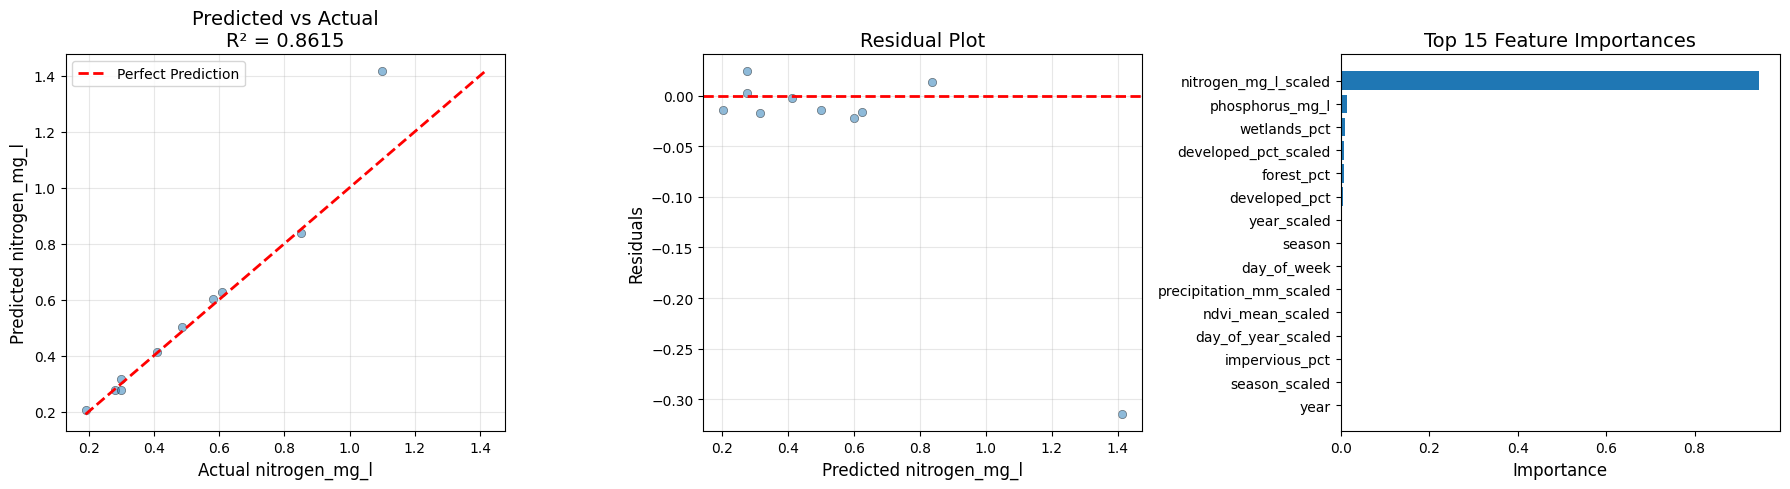


--- Training a second model (XGBoost) for comparison ---

Training xgboost model...
✓ Training complete in 0.08 seconds

STEP 9: Evaluate XGBoost model

MODEL EVALUATION - nitrogen_mg_l
Model Type: xgboost

Performance Metrics:
  R² Score:  0.9227
  RMSE:      0.0753
  MAE:       0.0343
  MAPE:      4.18%



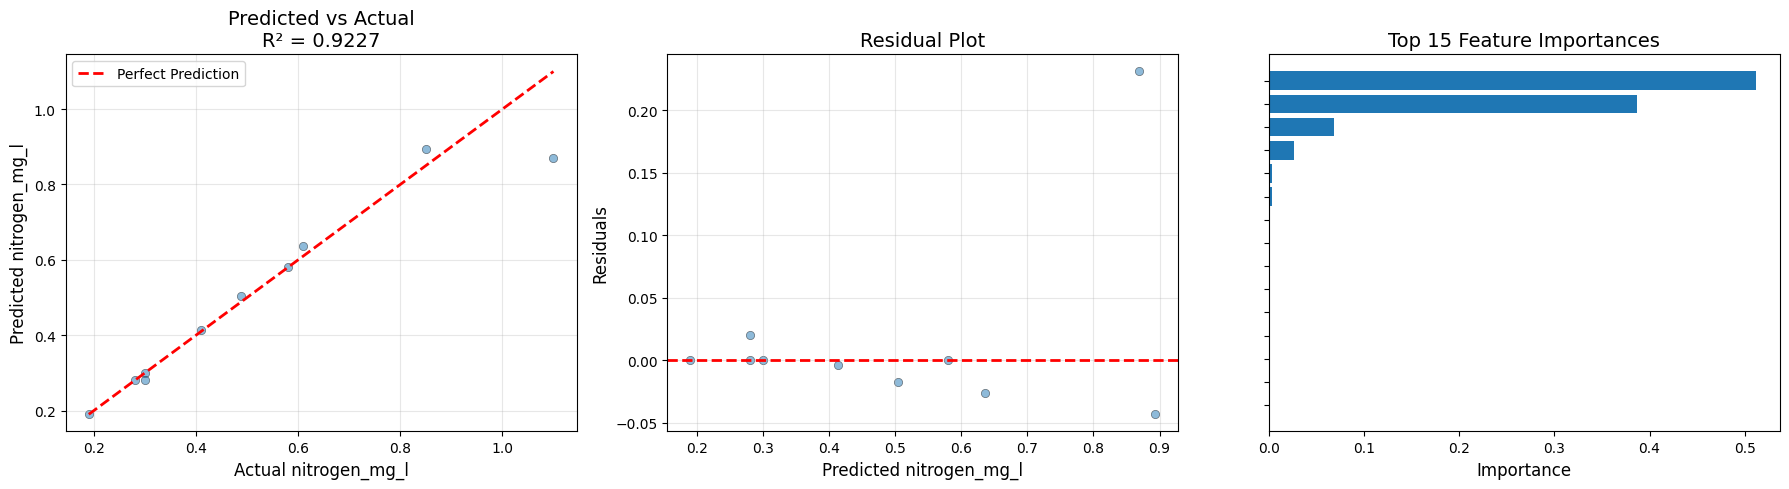

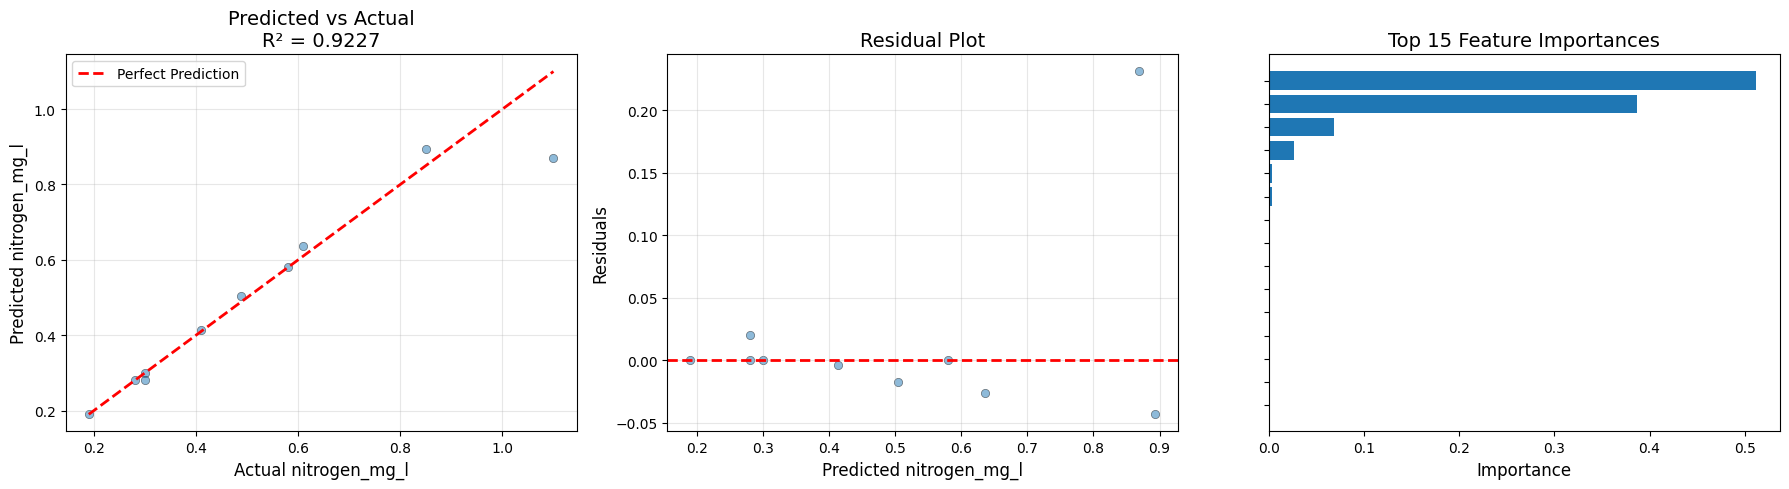

In [19]:
# @title
# COMPLETE PIPELINE: From CEDEN TSV to ML-ready features

# 1. Upload and load CEDEN data
print("STEP 1: Upload CEDEN data")
from google.colab import files # Import files here
uploaded = files.upload()
filename = list(uploaded.keys())[0]
ceden_data = pd.read_csv(filename, sep='\t', encoding='utf-8', low_memory=False)

# 2. Clean and prepare
print("\nSTEP 2: Clean data")
ceden_clean = clean_ceden_data(ceden_data)

# 3. Transform to wide format
print("\nSTEP 3: Transform to wide format")
wq_data = transform_ceden_to_wide(ceden_clean)

# 4. Handle issues
print("\nSTEP 4: Handle data issues")
wq_data_clean = handle_ceden_issues(wq_data)

# 5. Extract GEE features
print("\nSTEP 5: Extract GEE features")
df_features = extract_features_for_stations(
    wq_data_clean,
    extractor,
    sample_size=50  # Start with 50 for testing
)

# 6. Engineer additional features
print("\nSTEP 6: Engineer features")
df_engineered = engineer_features(df_features) # Moved from cell 584c7ea0

# 7. Save results
df_engineered.to_csv('sf_bay_ml_ready.csv', index=False)
print("\n✓ ML-ready dataset saved to sf_bay_ml_ready.csv")
print(f"Final dataset: {len(df_engineered)} rows, {len(df_engineered.columns)} columns")

# 8. Train models
print("\nSTEP 7: Train ML models")

# --- FIX 1: Correctly initialize the predictor ---
# 'target_variable' was misnamed 'target'
# 'df_engineered' is passed to 'prepare_data', not the constructor.
predictor = WaterQualityPredictor(
    target_variable='nitrogen_mg_l',
    model_type='random_forest'  # This is the model that will be trained
)

# --- FIX 2: Call methods correctly ---
# 'prepare_data' needs the dataframe and returns the train/test splits.
X_train, X_test, y_train, y_test = predictor.prepare_data(df_engineered)

# Call the generic 'train' method
predictor.train(X_train, y_train)

# Call 'evaluate' and 'plot_results'
print("\nSTEP 8: Evaluate Random Forest model")
predictor.evaluate(X_test, y_test)
predictor.plot_results(X_test, y_test)

# --- (Optional) To compare models, create a second predictor ---
print("\n--- Training a second model (XGBoost) for comparison ---")
xgb_predictor = WaterQualityPredictor(
    target_variable='nitrogen_mg_l',
    model_type='xgboost'
)
# Re-use the same data splits
xgb_predictor.train(X_train, y_train)
# FIX: Manually set feature_names for xgb_predictor since prepare_data was not called on it
xgb_predictor.feature_names = X_train.columns.tolist()
print("\nSTEP 9: Evaluate XGBoost model")
xgb_predictor.evaluate(X_test, y_test)
xgb_predictor.plot_results(X_test, y_test)

In [16]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Get unique station IDs and their last known coordinates from df_engineered
station_info = df_engineered[['station_id', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Determine the start date for predictions (one year after the last date in the current data)
latest_date = df_engineered['date'].max()
prediction_start_date = latest_date + timedelta(days=365) - timedelta(days=latest_date.dayofyear)
prediction_end_date = prediction_start_date + timedelta(days=364) # End of the next year

# Generate future dates (e.g., first of each month for the next year)
future_dates = pd.date_range(start=prediction_start_date.replace(day=1), end=prediction_end_date.replace(day=1), freq='MS')

# Create a DataFrame for future predictions
future_predictions_data = []

# Get the mean of GEE features from the existing engineered data
# Exclude 'station_id', 'date', 'latitude', 'longitude', 'nitrogen_mg_l', 'phosphorus_mg_l', and engineered temporal features for averaging

# Identify numerical GEE features (excluding target and identifiers)
gee_feature_cols = [col for col in df_engineered.columns if col not in ['station_id', 'date', 'latitude', 'longitude', 'nitrogen_mg_l', 'phosphorus_mg_l', 'month', 'season', 'year', 'day_of_year', 'day_of_week', 'ndvi_precip_interaction'] and 'scaled' not in col]

# Calculate the mean of these GEE features from the existing data
mean_gee_features = df_engineered[gee_feature_cols].mean().to_dict()

for _, station_row in station_info.iterrows():
    for future_date in future_dates:
        row_data = {
            'station_id': station_row['station_id'],
            'latitude': station_row['latitude'],
            'longitude': station_row['longitude'],
            'date': future_date,
            # Assign placeholder for target variables
            'nitrogen_mg_l': np.nan,
            'phosphorus_mg_l': np.nan,
        }
        # Add mean GEE features
        row_data.update(mean_gee_features)
        future_predictions_data.append(row_data)

df_future_raw = pd.DataFrame(future_predictions_data)
print(f"Generated {len(df_future_raw)} future prediction points.")
print("First 5 rows of raw future prediction data:")
display(df_future_raw.head())


Generated 546 future prediction points.
First 5 rows of raw future prediction data:


,station_id,latitude,longitude,date,nitrogen_mg_l,phosphorus_mg_l,water_pct,developed_pct,forest_pct,agriculture_pct,wetlands_pct,impervious_pct,ndvi_mean,ndvi_std,precipitation_mm,temperature_celsius
0,UP003,37.39657,-121.80505,2024-12-01,NaN,NaN,5.33089,49.176005,27.712846,0.552388,0.36348,25.004888,0.267899,0.10858,35.85451,26.728049
1,UP003,37.39657,-121.80505,2025-01-01,NaN,NaN,5.33089,49.176005,27.712846,0.552388,0.36348,25.004888,0.267899,0.10858,35.85451,26.728049
2,UP003,37.39657,-121.80505,2025-02-01,NaN,NaN,5.33089,49.176005,27.712846,0.552388,0.36348,25.004888,0.267899,0.10858,35.85451,26.728049
3,UP003,37.39657,-121.80505,2025-03-01,NaN,NaN,5.33089,49.176005,27.712846,0.552388,0.36348,25.004888,0.267899,0.10858,35.85451,26.728049
4,UP003,37.39657,-121.80505,2025-04-01,NaN,NaN,5.33089,49.176005,27.712846,0.552388,0.36348,25.004888,0.267899,0.10858,35.85451,26.728049
